# Get the DataSet

In [1]:
import pandas as pd

df_all_data = pd.read_csv('https://raw.githubusercontent.com/mphammer/HammerData/main/IMDB/IMDB%20Dataset.csv')

df_all_data.sample(10)

,review,sentiment
29983,This is one of my all-time favorites. Great mu...,positive
16686,I saw this movie in 1959 when I was 11 years o...,positive
2021,"I don't know much about Tobe Hooper, or why he...",negative
19049,Not a very good movie but according to the inf...,negative
31975,This movie could have been great(cause its got...,negative
1602,It's the worst movie I've ever seen. The actio...,negative
19904,Topless touch football!! A wet t-shirt contest...,positive
33406,"breathtaking, this is without doubt the best a...",positive
25387,When I caught a glimpse of the title I thought...,negative
6863,I went into this movie determined to like it. ...,negative


# Split Train and Test Data

I read that it's good to split your data early so that you don't look at your Test Data too much and unconsciously learn patterns about it.

Ref: Data Snooping Bias

In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_all_data, test_size=0.2)

In [3]:
print(df_train['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

sentiment
positive    20026
negative    19974
Name: count, dtype: int64
sentiment
negative    5026
positive    4974
Name: count, dtype: int64


# Clean the Sequence

We want to clean up the sentences and convert them into a list of words. This list of words will be the Sequence that we pass into our LSTM model.

Steps:
1. Remove "\<br />" that I saw in many reviews
2. Remove puncutation
3. Make everything lowercase
4. Split on spaces to get a list of words
5. Remove stop words

In [4]:
test_string = "The man's old uncle Dr. Joe ate all of the <food_name>! #Hangry <br /><br /> blah..."
test_string_saved = test_string

In [5]:
def remove_br(a_string):
  return a_string.replace("<br />", " ")

test_string = remove_br(test_string)
test_string

"The man's old uncle Dr. Joe ate all of the <food_name>! #Hangry    blah..."

In [6]:
import string
punctuation_set = set(string.punctuation)

def remove_punctuation(a_string):
  clean_character_array = [character if character not in punctuation_set else "" for character in a_string]
  return "".join(clean_character_array)

test_string = remove_punctuation(test_string)
test_string

'The mans old uncle Dr Joe ate all of the foodname Hangry    blah'

In [7]:
def to_lower(a_string):
  return a_string.lower()

test_string = to_lower(test_string)
test_string

'the mans old uncle dr joe ate all of the foodname hangry    blah'

In [8]:
def split_words(a_string):
  return [word for word in a_string.split(" ") if word != ''] # split on spaces and remove if empty string

test_list = split_words(test_string)
test_list

['the',
 'mans',
 'old',
 'uncle',
 'dr',
 'joe',
 'ate',
 'all',
 'of',
 'the',
 'foodname',
 'hangry',
 'blah']

In [9]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
stop_words = set(stopwords.words('english'))

def no_more_stopwords(a_list):
  return [word for word in a_list if word not in stop_words]

test_list = no_more_stopwords(test_list)
test_list

['mans', 'old', 'uncle', 'dr', 'joe', 'ate', 'foodname', 'hangry', 'blah']

In [11]:
def clean_string(a_string): # returns a list of tokens
  return no_more_stopwords(split_words(to_lower(remove_punctuation(remove_br(a_string)))))

clean_string(test_string_saved)

['mans', 'old', 'uncle', 'dr', 'joe', 'ate', 'foodname', 'hangry', 'blah']

In [13]:
df_train['clean_review'] = df_train['review'].apply(lambda review_str: clean_string(review_str))
df_test['clean_review'] = df_test['review'].apply(lambda review_str: clean_string(review_str))

In [15]:
df_train.head()

,review,sentiment,clean_review
29778,This could have been a good movie if more thin...,negative,"[could, good, movie, things, explained, way, m..."
275,I love to watch this movie a lot because of al...,positive,"[love, watch, movie, lot, scary, scenes, rapto..."
34623,I cant help it but i seem to like films that a...,negative,"[cant, help, seem, like, films, meant, scary, ..."
12718,"No gore, no blood, no gratifying death scenes....",negative,"[gore, blood, gratifying, death, scenesdumb, d..."
18703,"Seeing the title of this movie ""Stupid Teenage...",negative,"[seeing, title, movie, stupid, teenagers, must..."


# Preprocessing: Prepare Data for Training

## Convert Labels

In [16]:
df_train['sentiment'].value_counts()

df_train['label'] = (df_train['sentiment'] == 'positive') + 0 # convert bool to int 0/1
df_test['label'] = (df_test['sentiment'] == 'positive') + 0

df_train['label']

,label
29778,0
275,1
34623,0
12718,0
18703,0
...,...
35043,0
14003,1
23347,1
14850,1


## Create Embeddings for Words in the Sequences

We already stated that a Sequence will be a list of words, but we need to convert the words to numerical representations. For this, we will use Word2Vec to create embeddings.

In [17]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [18]:
from gensim.models import Word2Vec

EMBEDDING_SIZE = 50 # all words have the same size embedding vector

all_reviews = df_train['clean_review'].tolist()
all_reviews.extend(df_test['clean_review'].tolist())

w2v_model = Word2Vec(all_reviews, vector_size=EMBEDDING_SIZE)

In [19]:
w2v_model.wv['movie']

array([ 0.67213225, -0.02618729,  0.7258067 ,  1.7850623 ,  0.15573372,
       -0.94281   , -0.87689424, -1.0446999 , -0.64855814, -0.72217464,
        1.0861609 ,  0.8502496 ,  1.0690305 ,  0.7033583 ,  0.8783008 ,
       -0.77950454,  2.107481  ,  1.9847281 ,  0.36872882, -1.356798  ,
       -0.21783294, -0.31015685,  1.7958734 , -1.3989089 ,  2.4028828 ,
       -0.44714585, -0.10389818,  2.001257  ,  0.3018486 ,  1.1881951 ,
       -5.7427683 ,  1.0033897 ,  2.3725226 , -1.7584755 , -0.7458658 ,
       -0.10050604,  2.059365  , -1.3764833 , -0.80274355,  0.1835717 ,
        1.1895176 ,  3.2294204 , -0.94749165,  0.2096746 ,  0.20190012,
        1.3361295 , -0.6029741 ,  0.13253225, -2.6328058 , -0.37188932],
      dtype=float32)

In [20]:
# w2v_model.wv['movie']
# w2v_model.wv.key_to_index['computer']
# w2v_model.wv.index_to_key[0]

w2v_model.wv.most_similar('movie', topn=3)

[('film', 0.8678341507911682),
 ('flick', 0.7365527153015137),
 ('movies', 0.7119227051734924)]

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset

SEQUENCE_LENGTH = 100 # cap each review to 100 words (tokens)

def convert_sequences_to_tensor(sequences, num_tokens_in_sequence, embedding_size):
  '''
  We want a torch.FloatTensor() of size (num_sequences, num_tokens_in_sequence, embedding_size)
  '''
  num_sequences = len(sequences)
  print((num_sequences, num_tokens_in_sequence, embedding_size))

  data_tensor = torch.zeros((num_sequences, num_tokens_in_sequence, embedding_size))

  for index, review in enumerate(list(sequences)):
    # Create a word embedding for each word in the review (where a review is a sequence)
    truncated_clean_review = review[:num_tokens_in_sequence] # truncate to sequence length limit
    list_of_word_embeddings = [w2v_model.wv[word] if word in w2v_model.wv else [0.0]*embedding_size for word in truncated_clean_review]

    # convert the review to a tensor
    sequence_tensor = torch.FloatTensor(list_of_word_embeddings)

    # add the review to our tensor of data
    review_length = sequence_tensor.shape[0] # (review_length, embedding_size)
    data_tensor[index,:review_length,:] = sequence_tensor

  return data_tensor

In [25]:
train_data_X = convert_sequences_to_tensor(df_train['clean_review'].to_numpy(), SEQUENCE_LENGTH, EMBEDDING_SIZE)
train_data_y = torch.FloatTensor([int(d) for d in df_train['label'].to_numpy()])

test_data_X = convert_sequences_to_tensor(df_test['clean_review'].to_numpy(), SEQUENCE_LENGTH, EMBEDDING_SIZE)
test_data_y = torch.FloatTensor([int(d) for d in df_test['label'].to_numpy()])

(40000, 100, 50)


<ipython-input-24-3eae154a8606>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  sequence_tensor = torch.FloatTensor(list_of_word_embeddings)


(10000, 100, 50)


In [27]:
print("Example Sequence:")
print(train_data_X[0])

print("Example Label:")
print(train_data_y[0])

Example Sequence:
tensor([[-0.0276, -0.8027, -3.0030,  ..., -0.1803,  0.5112, -3.1513],
        [ 0.0444, -0.4281,  0.2155,  ..., -0.8970, -1.0710, -0.8860],
        [ 0.6721, -0.0262,  0.7258,  ...,  0.1325, -2.6328, -0.3719],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
Example Label:
tensor(0.)


In [30]:
train_data = TensorDataset(train_data_X, train_data_y)
test_data = TensorDataset(test_data_X, test_data_y)

In [34]:
batch_size = 100
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Create the Model

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
import torch.nn as nn

class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers, drop_prob=0.7):
    '''
    lstm_input_dim: number of values in an embedding
    '''
    super(LSTMModel,self).__init__()

    self.num_stacked_layers = num_stacked_layers
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        num_layers = num_stacked_layers,
        batch_first = True
      )

    self.dropout = nn.Dropout(drop_prob) # randomly sets outputs of a tensor to 0 during training

    self.fc = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    '''
    x -> (batch_size, sequence_size, embedding_size)
    '''
    batch_size = x.size(0)

    # Initialize the cell state and hidden state
    h0 = torch.zeros((self.num_stacked_layers, batch_size, self.hidden_size)).to(device)
    c0 = torch.zeros((self.num_stacked_layers, batch_size, self.hidden_size)).to(device)

    # Call the LSTM
    lstm_out, hidden = self.lstm(x, (h0, c0))

    # contiguous() moves all data into 1 block of memory on the GPU
    # (batch_size, sequence_size, embedding_size) -> (batch_size*sequence_size, embedding_size)
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

    # dropout and fully connected layer
    lstm_out = self.dropout(lstm_out) # Only during training
    fc_out = self.fc(lstm_out)

    # apply the sigmoid function to maps the value to somewhere between 0 and 1
    sigmoid_out = self.sigmoid(fc_out)

    # reshape to be batch_size first - every batch has a value between 0 and 1
    sigmoid_out = sigmoid_out.view(batch_size, -1) # a list of lists with single elements
    sigmoid_out = sigmoid_out[:, -1] # get the output labels as a list

    # return last sigmoid output and hidden state
    return sigmoid_out, hidden

In [39]:
LSTM_INPUT_SIZE = EMBEDDING_SIZE # size of the embeddings
LSTM_HIDDEN_SIZE = 128
LSTM_NUM_STACKED_LAYERS = 2

lstm_model = LSTMModel(LSTM_INPUT_SIZE, LSTM_HIDDEN_SIZE, LSTM_NUM_STACKED_LAYERS)
lstm_model.to(device)
print(lstm_model)

LSTMModel(
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Training Loop

In [41]:
import numpy as np

lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
epochs = 15

def accuracy(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [42]:
# Training loop
def train_loop(model, train_loader, optimizer, criterion):
  model.train()
  train_accuracy = 0.0
  train_losses = []
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs, h = model(inputs) # Forward pass
    loss = criterion(outputs, labels) # Calculate the loss
    optimizer.zero_grad() # Clear out all previous gradients
    loss.backward() # Calculate new gradients
    optimizer.step() # Update parametres using the gradients

    train_losses.append(loss.item())
    train_accuracy += accuracy(outputs, labels)

  epoch_train_loss = np.mean(train_losses)
  epoch_train_acc = (train_accuracy/len(train_loader.dataset))*100.0
  return (epoch_train_loss, epoch_train_acc)

# Test/Validation Loop
def test_loop(model, test_loader, criterion):
  model.eval()
  test_accuracy = 0.0
  test_losses = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      outputs, val_h = model(inputs)
      loss = criterion(outputs, labels)

      test_losses.append(loss.item())
      test_accuracy += accuracy(outputs, labels)

  epoch_test_loss = np.mean(test_losses)
  epoch_test_accuracy = (test_accuracy/len(test_loader.dataset))*100.0

  return (epoch_test_loss, epoch_test_accuracy)

# Training and validation loop
epoch_train_losses = []
epoch_train_accs = []
epoch_test_losses = []
epoch_test_accs = []
for epoch in range(epochs):
  epoch_train_loss, epoch_train_acc = train_loop(lstm_model, train_loader, optimizer, criterion)
  epoch_test_loss, epoch_test_acc = test_loop(lstm_model, test_loader, criterion)

  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.4f} | Test Loss: {epoch_test_loss:.4f} Test Acc: {epoch_test_acc:.4f}')

  epoch_train_losses.append(epoch_train_loss)
  epoch_train_accs.append(epoch_train_acc)
  epoch_test_losses.append(epoch_test_loss)
  epoch_test_accs.append(epoch_test_acc)

Epoch 1/15, Train Loss: 0.6181 Train Acc: 66.7475 | Test Loss: 0.5781 Test Acc: 75.3100
Epoch 2/15, Train Loss: 0.5895 Train Acc: 70.6300 | Test Loss: 0.6807 Test Acc: 55.7400
Epoch 3/15, Train Loss: 0.5995 Train Acc: 70.2875 | Test Loss: 0.6309 Test Acc: 65.8600
Epoch 4/15, Train Loss: 0.5615 Train Acc: 74.8050 | Test Loss: 0.5211 Test Acc: 77.2100
Epoch 5/15, Train Loss: 0.6148 Train Acc: 64.1050 | Test Loss: 0.6930 Test Acc: 50.6300
Epoch 6/15, Train Loss: 0.6919 Train Acc: 51.7300 | Test Loss: 0.6930 Test Acc: 50.2600
Epoch 7/15, Train Loss: 0.6934 Train Acc: 50.4975 | Test Loss: 0.6939 Test Acc: 49.7200
Epoch 8/15, Train Loss: 0.6933 Train Acc: 50.5275 | Test Loss: 0.6923 Test Acc: 52.1400
Epoch 9/15, Train Loss: 0.6921 Train Acc: 52.1975 | Test Loss: 0.6802 Test Acc: 57.8000
Epoch 10/15, Train Loss: 0.5810 Train Acc: 70.2250 | Test Loss: 0.4205 Test Acc: 82.3400
Epoch 11/15, Train Loss: 0.3981 Train Acc: 83.1825 | Test Loss: 0.3875 Test Acc: 83.0000
Epoch 12/15, Train Loss: 0.362

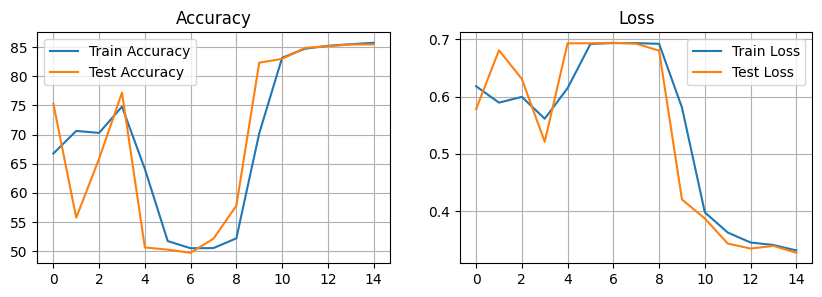

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 3))

plt.subplot(1, 2, 1)
plt.plot(epoch_train_accs, label='Train Accuracy')
plt.plot(epoch_test_accs, label='Test Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_train_losses, label='Train Loss')
plt.plot(epoch_test_losses, label='Test Loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()